In [2]:
from elastic_body import *
from utils import *
from progress import ProgressBarText

import scipy.integrate
import matplotlib.pyplot as plt
import os

### Load parameters

In [3]:
# parse the material file (viscoelastic moduli)
material_file = open(os.path.join(PROJ_PATH, PARAMS_DIR, 
                                  'model_material4_strong_nonlin_visc'))
moduli_dict = parse_input_file(material_file)
material_file.close()

# parse the body file (geometry and mesh)
body_file = open(os.path.join(PROJ_PATH, PARAMS_DIR, 'rod_150_1'))
geometry_dict = parse_input_file(body_file)
body_file.close()

params_dict = {**moduli_dict, **geometry_dict}
body, mesh = create_body_and_mesh(params_dict)

### Set initial condition

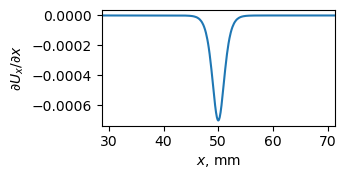

In [4]:
output_prefix = 'example_simulation_mat4_'
x = mesh.mesh1.mesh1.grid()[0]
r = mesh.mesh1.mesh2.grid()[0]

# set A0 (signed amplitude), L0 (width), and m (position)
A0 = -0.0007
L0 = body.soliton_kdv_width(A0)
m = 50.
# get the soliton profile
u00x, u00 = body.soliton_kdv(A0, x - m, 0)

u0_func = np.zeros((body.ndim,) + mesh.shape)
# set the axial displacement
u0_func[0] += u00[:,None,None]
# set the radial displacement (according to the Love's hypothesis)
u0_func[1] -= body.poiss * np.tensordot(u00x, r, axes=0)[:,:,None]

# create the displacement field (u0)
u0 = TensorField(mesh, u0_func)
# create velocity field (v0 = du0/dt)
gamma = lame2young(body.xi, body.eta)[0] / body.young
v0 = -(body.c0 + body.soliton_kdv_velocity_delta(A0) + 
       body.c0/2 * gamma@I2lin(2*body.c0*body.tau/L0))*u0.diff()

# plot the initial condition
plt.figure(figsize=(3,1.5))
plt.plot(x, u0[0].diff()(x,0,0))
plt.ylabel("$\\partial U_x / \\partial x$")
plt.xlabel("$x$, mm")
plt.xlim([m - 30*body.Rg, m + 30*body.Rg])
plt.show()

Compare the amplitude to the $\beta/\gamma$ ratio ($\beta$ is the quadratic nonlinearity coefficient in KdV and $\gamma$ is the cubic coefficient). If the amplitude is much smaller than this ratio, the higher order nonlinearity can be neglected.

In [6]:
print(f"beta = {body.beta:.1f}, gamma = {body.gamma:.1f}")
print(f"beta/gamma = {body.beta/body.gamma:.1e}, amplitude = {np.abs(A0):.1e}")

beta = -219.5, gamma = -27271.0
beta/gamma = 8.0e-03, amplitude = 7.0e-04


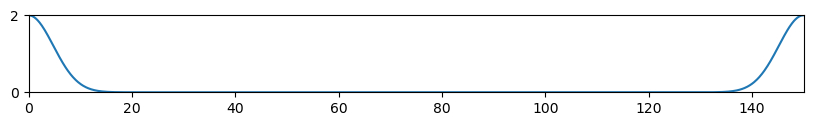

In [12]:
# sponge function
x = mesh.mesh1.mesh1.grid()[0]
sponge_mask = np.logical_or(x<=body.L/5, x>=4*body.L/5)[:,None,None]

def sponge(t):
    data = np.zeros(mesh.shape, dtype=float)
    data += 2.*np.cos(np.pi*(x[:,None,None] - body.c0*t)/body.L)**100 * sponge_mask
    return TensorField(mesh, data)

plt.figure(figsize=(10,1))
plt.plot(x, sponge(0)(x, 0, 0))
plt.xticks(np.arange(0, 201, 20))
plt.margins(0)
plt.show()

In [13]:
# set time
t0 = 0
t_max = 300
dt = 10
params_dict[STOP_TIME] = t_max
params_dict[TIME_STEP] = dt
params_dict[START_TIME] = t0
# create arrays
T = np.arange(t0, t_max + dt/2, dt)
U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
U[0] = u0

# save all parameters
res_path = os.path.join(PROJ_PATH, RESULTS_DIR)
if not os.path.exists(res_path):
    os.mkdir(res_path)
save_params(os.path.join(res_path, output_prefix + PARAMS_FILENAME), params_dict)

# prepare the simulation
def derivative(t, y):
    bval = tuple([(0, 0),] * (body.ndim))
    vects = decompress_tens_ret(y, mesh, ret_num=body.ret_num)
    ders = body.derivative_nonlin(bval, *vects, sponge=sponge(t))
    return compress_tens_ret(*ders)

integr = sp.integrate.ode(derivative)
integr.set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e6)

if body.is_retarded:
    # initialize the retarded (memory) variables with 0
    r0 = TensorField(mesh, np.zeros((body.ret_num, 3, 3) + mesh.shape))
    integr.set_initial_value(compress_tens_ret(u0, v0, r0), t=t0)
else:
    integr.set_initial_value(compress(u0, v0), t=t0)

### Simulate

In [14]:
for k, t in enumerate(ProgressBarText(T[1:]), 1):
    if t > integr.t:
        integr.integrate(t)
    U[k] = decompress_tens_ret(integr.y, mesh, ret_num=body.ret_num)[0]

Progress: |██████████████████████████████| 100.0% Elapsed: 1:04:41, Estimated: 1:04:41


### View the result and save

Text(0.5, 0, 'moving coordinate, $x - ct$')

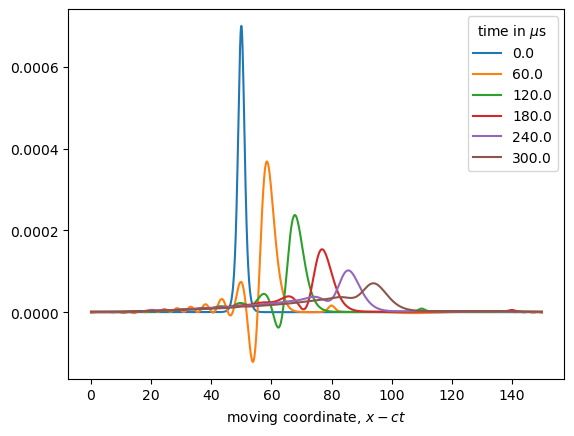

In [15]:
for k in range(0, len(T), len(T)//5):
    plt.plot(x, -U[k, 0].diff()(x + body.c0*T[k], 0, 0), label=str(T[k]))
plt.legend(title="time in $\\mu$s")
plt.xlabel("moving coordinate, $x - ct$")

In [16]:
# save simulation (the displacement field only)
np.save(os.path.join(res_path, output_prefix + U_FILENAME), U.func)